## [tool] 1. PR Vulnerability Detection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

import settings
from utils import vplot, vprint

In [25]:
FILTERED_DIR = settings.DATA_CONFIG['distilled_dir']
RAW_DIR = settings.DATA_CONFIG['raw_dir']

FRAMEWORK = "pytorch"

MERGED_PR_FILE = FILTERED_DIR + f'merged_{FRAMEWORK}_pr.csv'
VULN_PR_FILE = FILTERED_DIR + f'vuln_{FRAMEWORK}_pr.csv'

In [26]:
merged_pr_df = pd.read_csv(MERGED_PR_FILE)
merged_pr_df.columns

Index(['number', 'html', 'title', 'description', 'comments_count',
       'review_comments_count', 'commits_count', 'line_additions',
       'line_deletions', 'changed_files_count', 'created_at', 'updated_at',
       'closed_at', 'merged_at'],
      dtype='object')

## Merged Pull Request File

In [27]:
merged_pr_df = pd.read_csv(MERGED_PR_FILE)
len(merged_pr_df.index)

5295

## Apply Vulnerability Search Key

In [28]:
from searchkey import VulnerabilityRegex
REGEX_VULN = VulnerabilityRegex.basic() + '|' + VulnerabilityRegex.enhence()
REGEX_VULN

'div(i(de|sion)(s)?)?.by.(zero|0)|int(eger)?.truncation|int(eger)?.overflow|floating.point.exception|\\bfpe\\b|out(side)?.of.memory|\\boom\\b|(data|memory).leak|(data|memory).corruption|infinite.loop|invalid.memory.access|access.(\\w+.)?invalid.memory|write.(\\w+.)?immutable.memory|access.(\\w+.)?undefined.memory|arbitrary.memory.(read|write|access)|null(.)?(pointer|ptr)?(.)?deref(erence)?|deref(erenc(e|ing))?.of.null(.)?(pointer|ptr)?|reference.binding.to.null(.)?(pointer|ptr)?|null(.)?(pointer|ptr)?(.)?exception|\\bnpe\\b|use.after.free|heap.(buffer.)?overflow|stack.overflow(?!.com)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).read|read.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).write|write.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b).access|access.(out(side)?.of.bound(s)?|\\boob\\b)|(heap.)?(out(side)?.of.bound(s)?|\\boob\\b)(?!.(read|write))|overflow|uninitialized|((incomplete|incorrect|lack.of|invalid|missing).

##### Search Keyword from Title

In [29]:
merged_pr_df['title keyword'] = merged_pr_df['title'].str.extract(f"({REGEX_VULN})", flags=re.IGNORECASE)[0].str.lower()

##### Search Keyword from Description

In [30]:
merged_pr_df['description keyword'] = merged_pr_df['description'].str.extract(f"({REGEX_VULN})", flags=re.IGNORECASE)[0].str.lower()

##### Extract the vulnerable record

In [31]:
is_vulnerable = ~merged_pr_df['title keyword'].isnull() | ~merged_pr_df['description keyword'].isnull()
vuln_pr_df = merged_pr_df[is_vulnerable].reset_index(drop=True)

##### Normalize

In [32]:
vuln_pr_df['title keyword'] = VulnerabilityRegex.normalize_enhence_searchkey(vuln_pr_df['title keyword'])
vuln_pr_df['title keyword'] = VulnerabilityRegex.normalize_searchkey(vuln_pr_df['title keyword'])

vuln_pr_df['description keyword'] = VulnerabilityRegex.normalize_enhence_searchkey(vuln_pr_df['description keyword'])
vuln_pr_df['description keyword'] = VulnerabilityRegex.normalize_searchkey(vuln_pr_df['description keyword'])

In [33]:
len(vuln_pr_df.index)

285

### Analysis

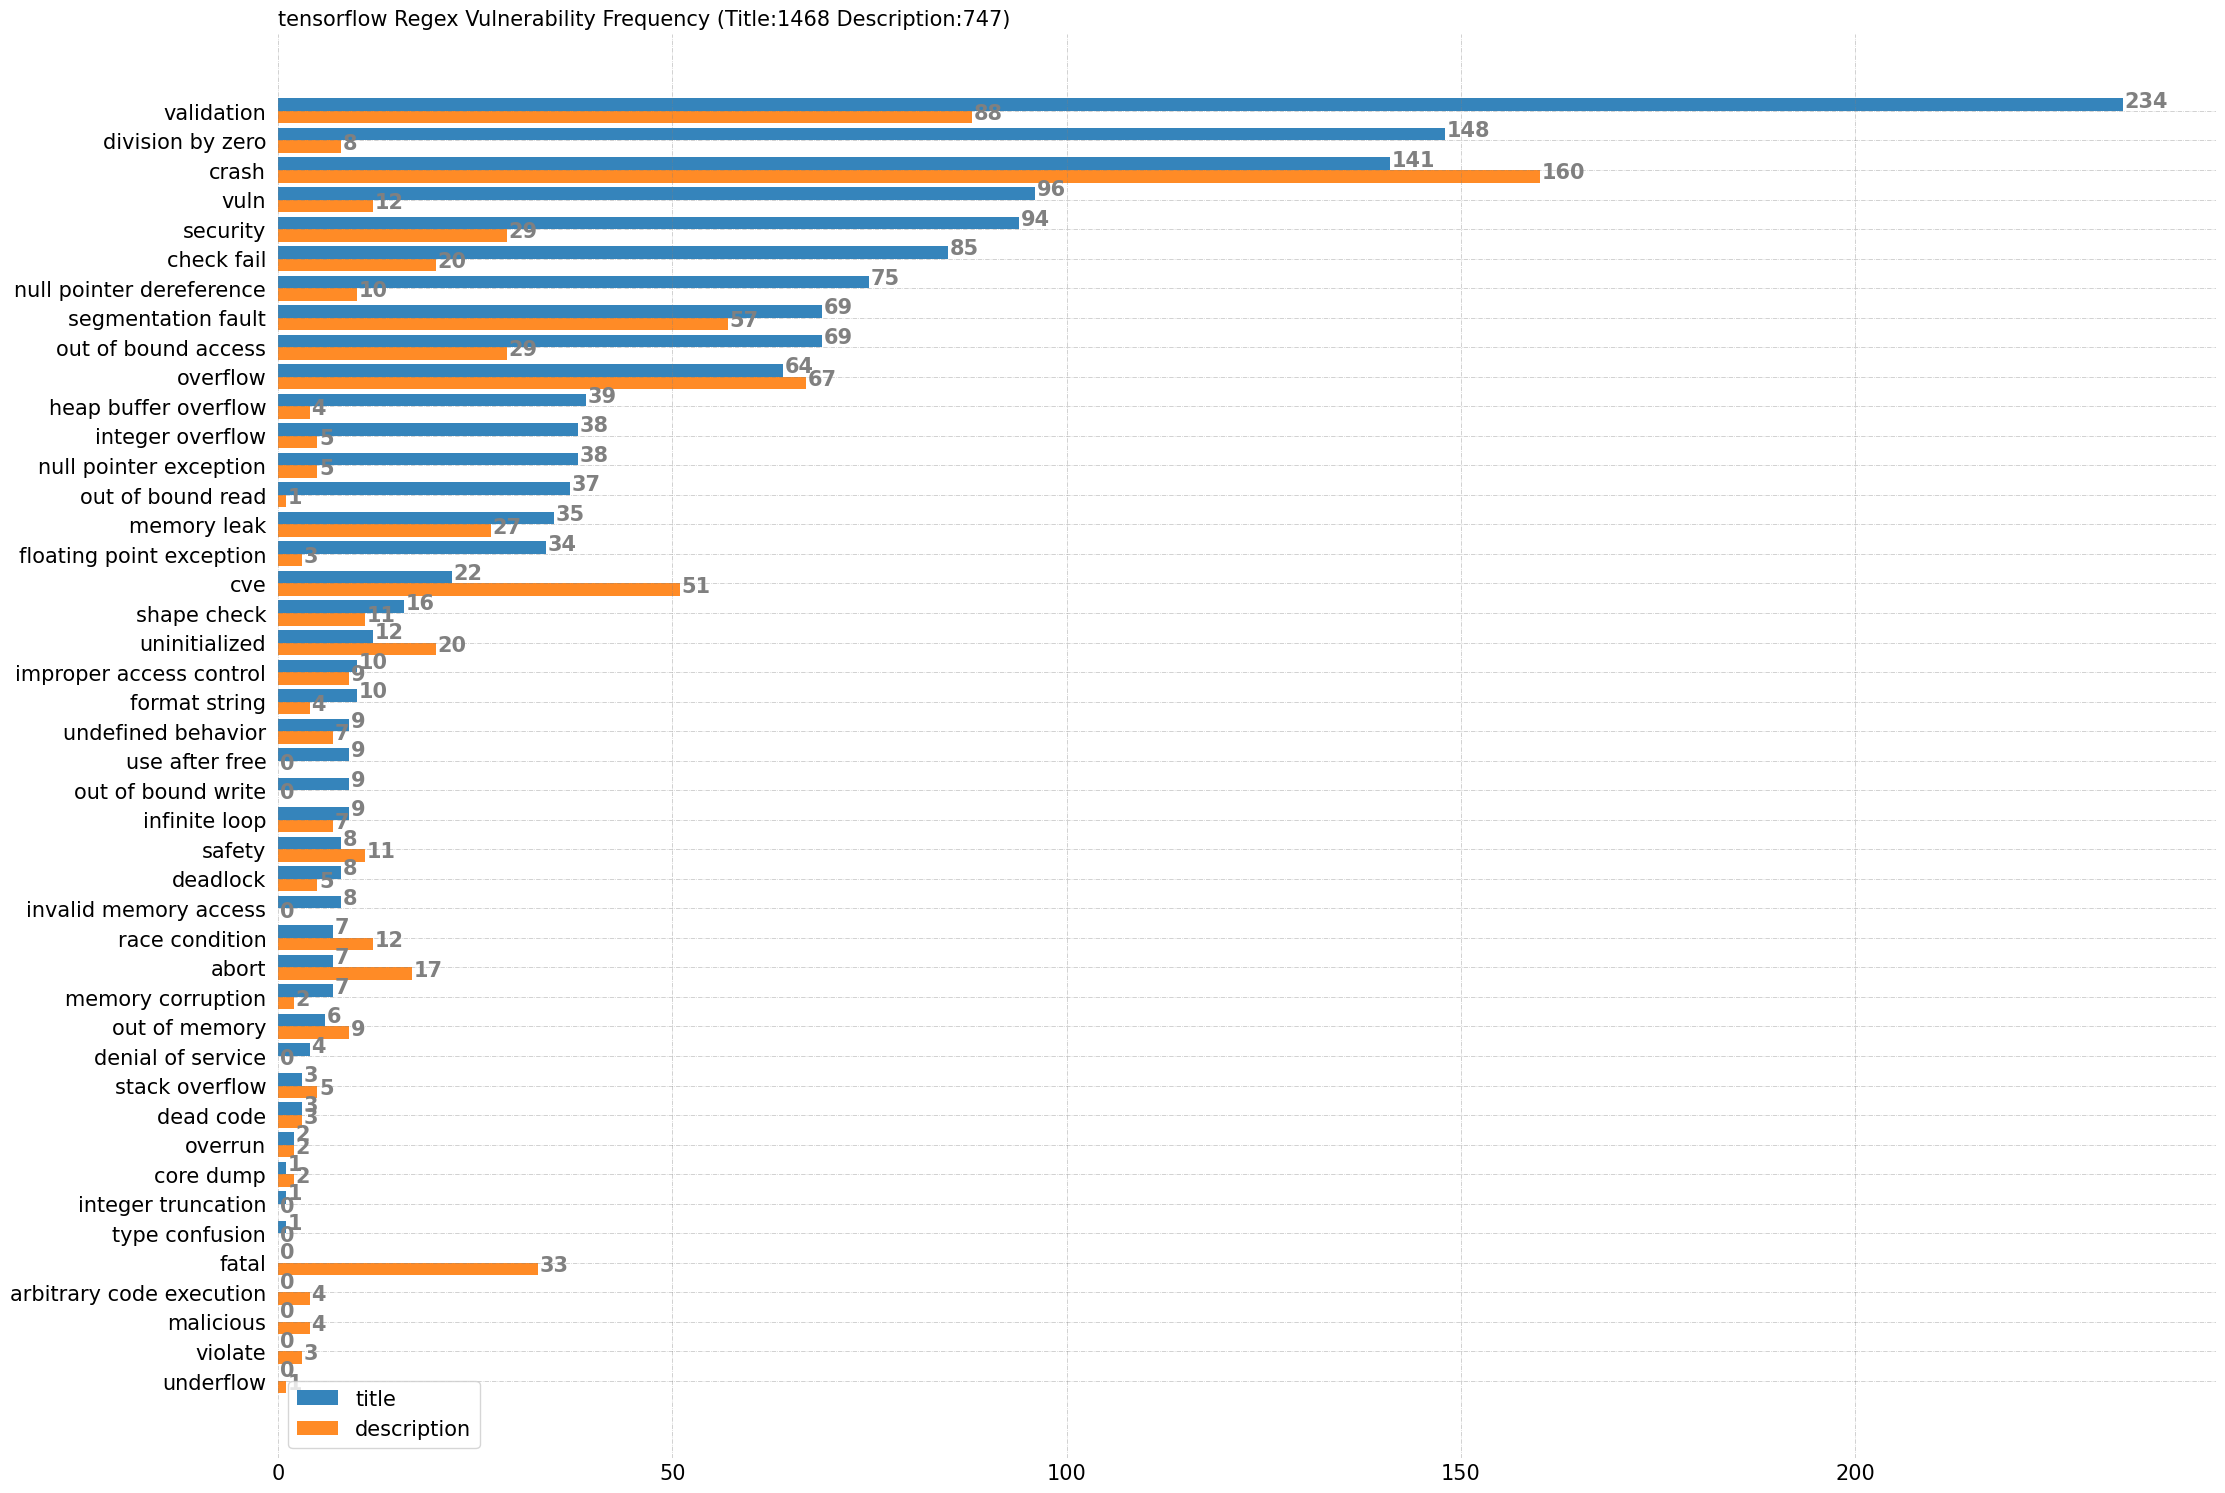

In [11]:
title_keyword_series = vuln_pr_df['title keyword'].value_counts()
description_keyword_series = vuln_pr_df['description keyword'].value_counts()

vuln_freq_df = pd.concat(objs=[title_keyword_series.rename("title"), description_keyword_series.rename("description")], axis=1).fillna(0).astype('int64')
vplot.multi_barh(vuln_freq_df, col_names=['title','description'], title=f'{FRAMEWORK} Regex Vulnerability Frequency (Title:{title_keyword_series.sum()} Description:{description_keyword_series.sum()})', fontsize=15, fig_yscale=0.5)

### Insight

In [12]:
keyword_only_in_title = ~vuln_pr_df['title keyword'].isnull() & vuln_pr_df['description keyword'].isnull()
keyword_only_in_description = vuln_pr_df['title keyword'].isnull() & ~vuln_pr_df['description keyword'].isnull()
keyword_in_both = ~vuln_pr_df['title keyword'].isnull() & ~vuln_pr_df['description keyword'].isnull()

title_only_df = vuln_pr_df[keyword_only_in_title].reset_index(drop=True)
description_only_df = vuln_pr_df[keyword_only_in_description].reset_index(drop=True)
both_df = vuln_pr_df[keyword_in_both].reset_index(drop=True)

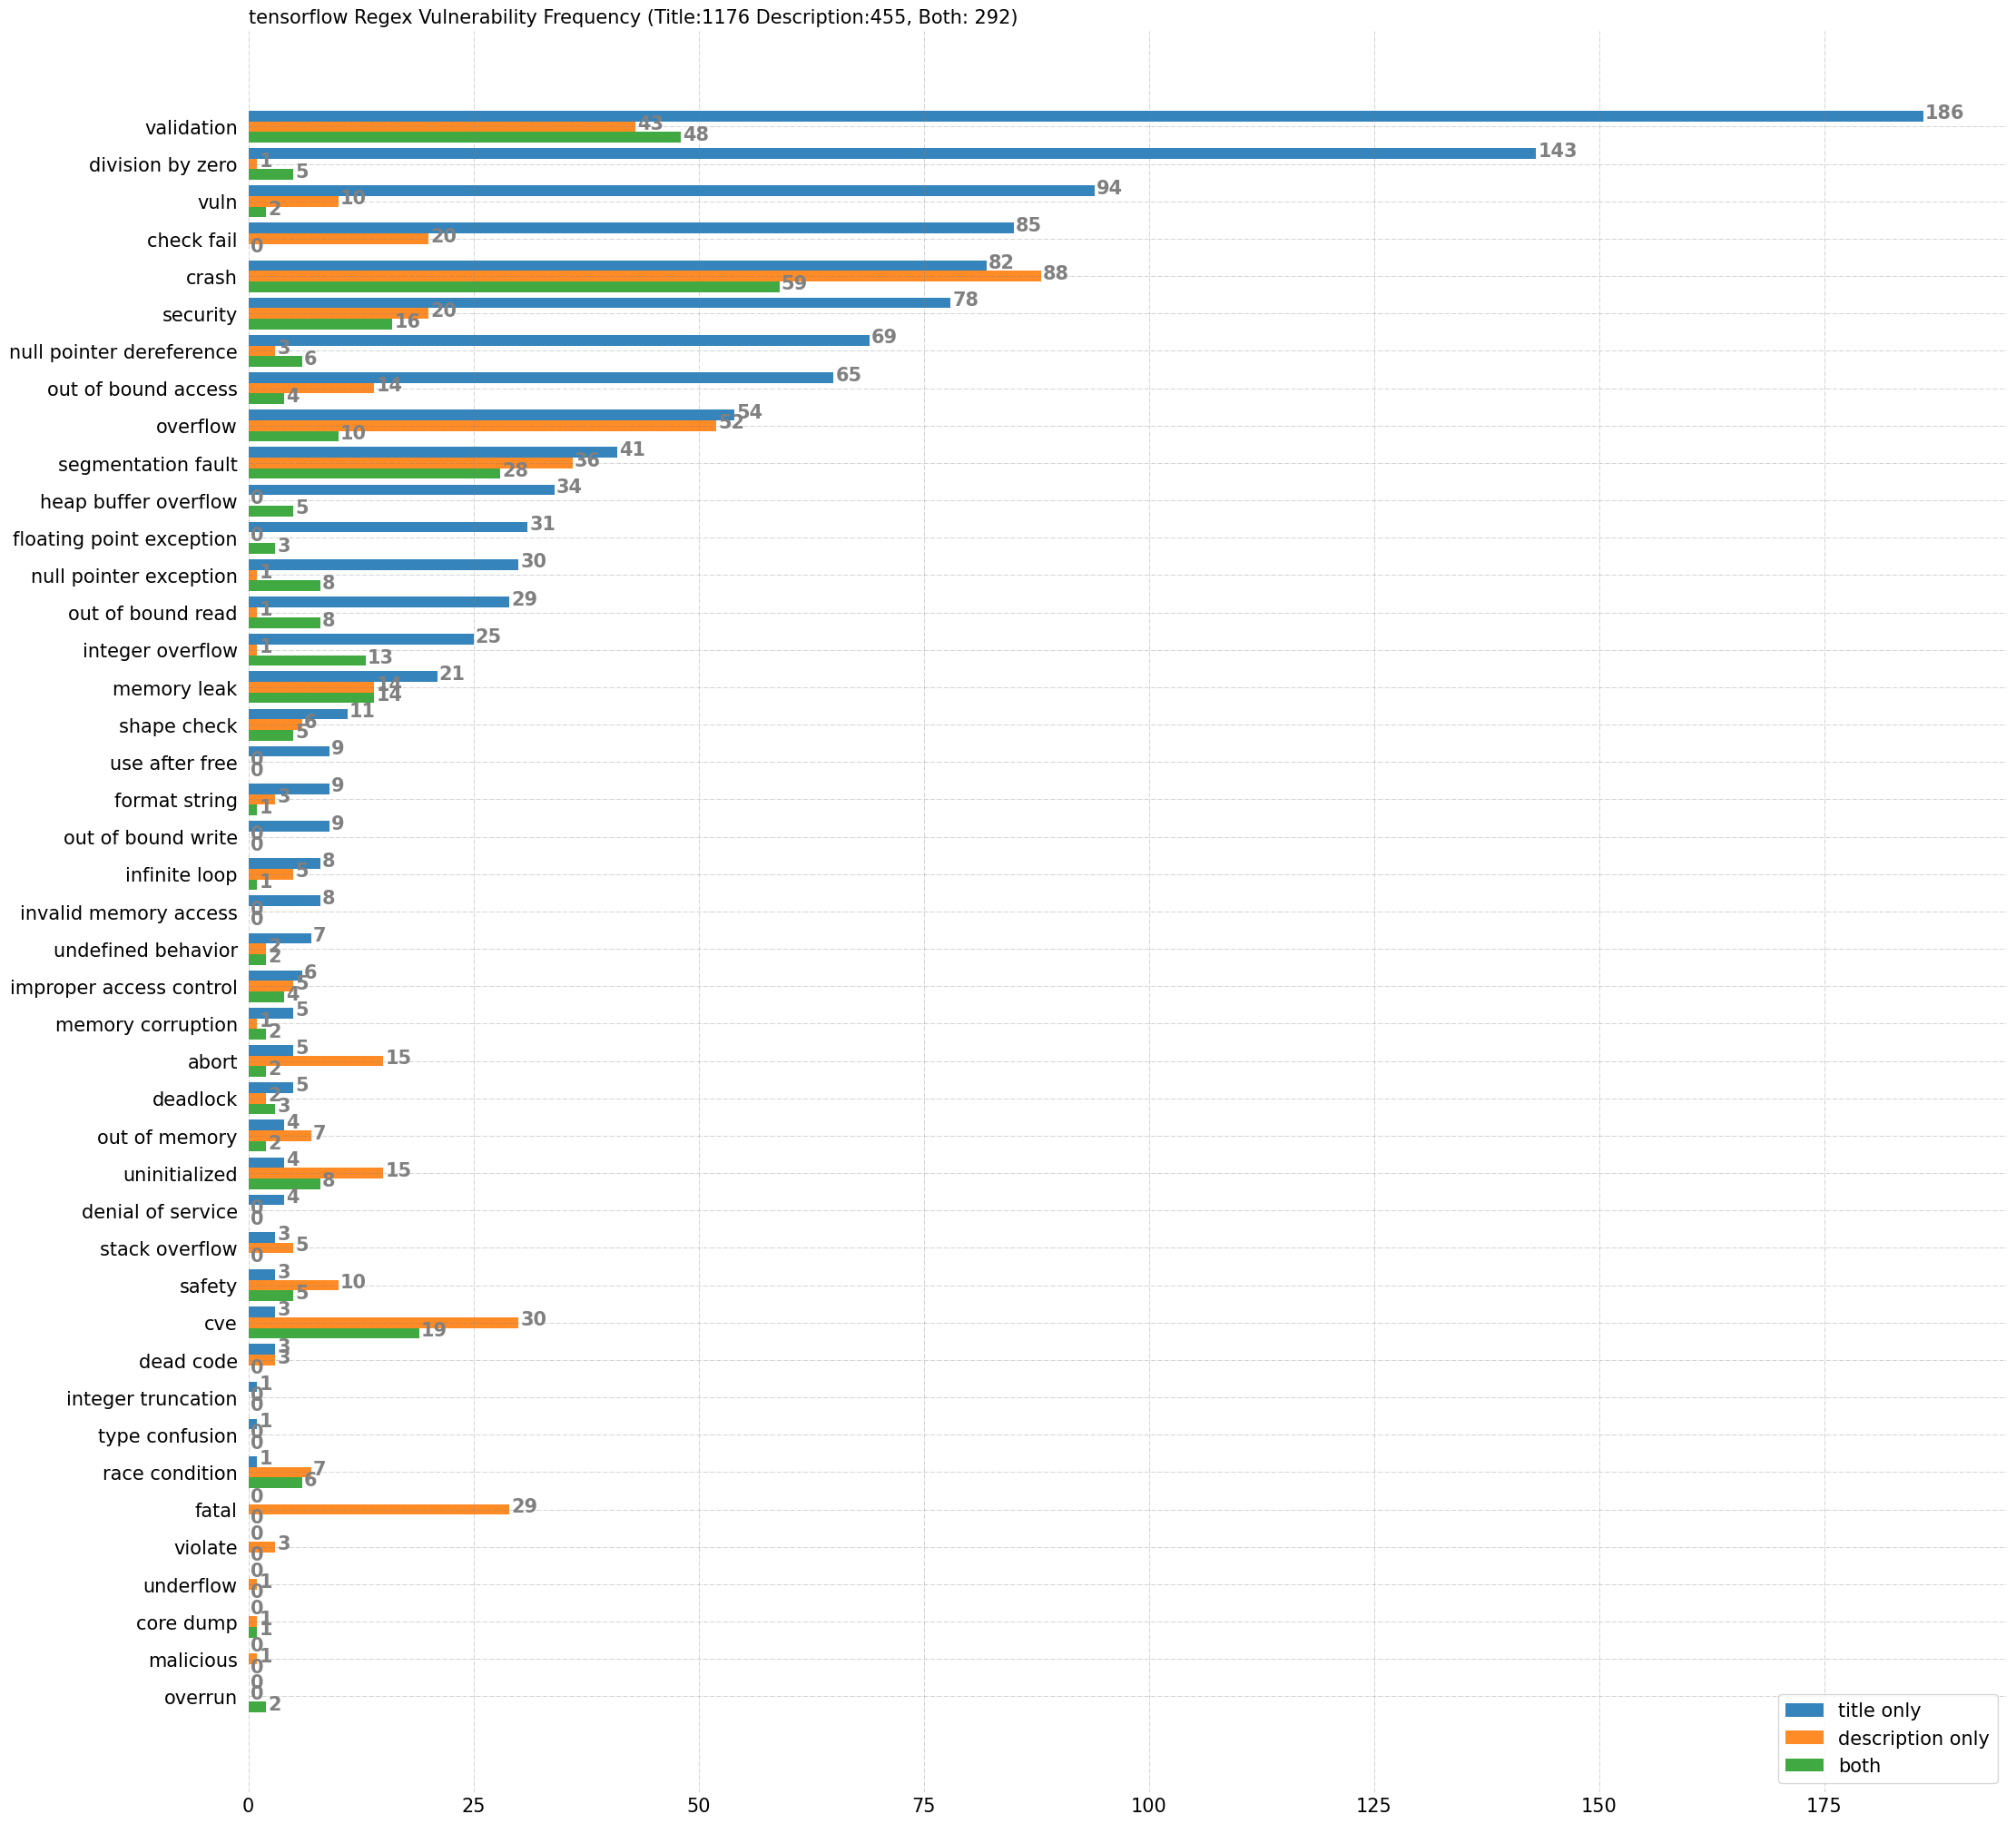

In [13]:
title_keyword_series = title_only_df['title keyword'].value_counts()
description_keyword_series = description_only_df['description keyword'].value_counts()
both_keyword_series = both_df['title keyword'].value_counts()

diff_vuln_freq_df = pd.concat(objs=[
    title_keyword_series.rename("title only"), 
    description_keyword_series.rename("description only"),
    both_keyword_series.rename("both")], axis=1).fillna(0).astype('int64')
vplot.multi_barh(diff_vuln_freq_df, 
                 col_names=['title only','description only','both'], 
                 title=f'{FRAMEWORK} Regex Vulnerability Frequency (Title:{title_keyword_series.sum()} Description:{description_keyword_series.sum()}, Both: {both_keyword_series.sum()})',
                 fontsize=15, fig_yscale=0.7)

##### Text in Description only

In [14]:
vprint.df_col_by_keyword(df=description_only_df,keyword='crash',search_col_name='description keyword',info_col_name='description',n=2)

3 	 This fixes a crash when AddN elementwise operation is executed with constant layer as input(s) to the AddN node. In this case the Const nodes are not recognized as tensors and in those cases the batch dimension is always removed. This causes a mismatch of input tensor sizes causing the crash/native segment fallback. Only when implicit batch mode is used, the batch dimension must be removed to match the other input tensor sizes. 

![image](https://user-images.githubusercontent.com/33809857/200448584-a416ce70-2f5f-488f-a708-bc8d3b80e8e2.png)


Replacing PR: #58474  
@DEKHTIARJonathan  Please review
4 	 …thon tuple

Returns InternalError if a non UTF-8 string is passed in as token, instead of crashing.

PiperOrigin-RevId: 478123498
Total:2


## Output

In [15]:
os.makedirs(FILTERED_DIR, exist_ok=True) 
# vuln_pr_df = vuln_pr_df.replace(',',' ', regex=True)
# vuln_pr_df = vuln_pr_df.replace({r'\r\n': ' '}, regex=True)
# vuln_pr_df = vuln_pr_df.replace({r'\n': ' '}, regex=True)
vuln_pr_df.to_csv(VULN_PR_FILE, index=False)